# Лабораторная работа 3.1 Анализ и визуализация временного ряда бизнес-показателей


**Цель работы.** Освоить ключевые методы анализа временных рядов на языке Python для решения практических бизнес-задач, таких как прогнозирование, выявление трендов и сезонности в экономических показателях.

## Введение. Почему временные ряды важны для бизнеса?

Временные ряды — это наборы данных, где каждая точка привязана к определенному моменту времени. Для бизнес-информатики это один из самых ценных активов, позволяющий:

- **Прогнозировать спрос.** Оптимизировать запасы и логистику.
- **Анализировать финансовые рынки.** Предсказывать цены акций и курсы валют.
- **Оценивать эффективность маркетинга.** Отслеживать влияние рекламных кампаний на продажи во времени.
- **Планировать ресурсы.** Прогнозировать нагрузку на серверы или количество обращений в колл-центр.

В этой работе мы научимся извлекать из временных данных ценные инсайты, строить и оценивать прогнозные модели.

### Основные характеристики временных рядов

- **Тренд (Trend).** Долгосрочное направление движения ряда (рост, падение, стагнация).
- **Сезонность (Seasonality).** Периодические, повторяющиеся колебания (например, рост продаж перед Новым годом).
- **Циклы (Cycles).** Долгосрочные волнообразные колебания, не связанные с фиксированным периодом, как у сезонности (например, экономические циклы).
- **Шум (Noise/Residual).** Случайные, непрогнозируемые колебания.
- **Стационарность.** Свойство ряда, при котором его статистические характеристики (среднее, дисперсия) не меняются со временем. Большинство моделей требуют, чтобы ряд был стационарным.

## Часть 1. Подготовка к анализу

Перед началом работы установим и импортируем все необходимые библиотеки.

In [4]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Настройки для визуализаций
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### Работа с датами и временем в Pandas

Правильная работа с временными метками — основа анализа временных рядов. Pandas предоставляет мощный инструментарий для этого.

**Задание 1. Создание DataFrame и преобразование в формат даты**

Создайте DataFrame на основе предоставленных данных о продажах. Преобразуйте столбец `'Дата'` в специальный формат `datetime` с помощью `pd.to_datetime()` и выведите типы данных DataFrame с помощью `.info()`.

In [7]:
data = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
        'Продажи': [1000, 1200, 1300, 1100, 1400]}

# 1. Создайте DataFrame 'df' из словаря 'data'
df = pd.DataFrame(data)

# 2. Преобразуйте столбец 'Дата'
df['Дата'] = pd.to_datetime(df['Дата'])

# 3. Выведите информацию о DataFrame
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Дата     5 non-null      datetime64[ns]
 1   Продажи  5 non-null      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 212.0 bytes


,Дата,Продажи
0,2023-01-01,1000
1,2023-02-01,1200
2,2023-03-01,1300
3,2023-04-01,1100
4,2023-05-01,1400


**Задание 2. Установка временного индекса**

Для удобной работы с временными рядами столбец с датами часто устанавливают в качестве индекса DataFrame. Используйте метод `.set_index()` для установки столбца `'Дата'` в качестве индекса.

In [9]:
# Установите 'Дата' в качестве индекса для df
df = df.set_index('Дата')
df

,Продажи
Дата,
2023-01-01,1000
2023-02-01,1200
2023-03-01,1300
2023-04-01,1100
2023-05-01,1400


**Задание 3. Фильтрация данных по дате**

Используя временной индекс, выберите данные о продажах за период с марта по апрель 2023 года включительно.

In [11]:
# Фильтрация данных о продажах за период с марта по апрель 2023 года включительно
sales_mar_apr_2023 = df.loc['2023-03':'2023-04']
sales_mar_apr_2023

,Продажи
Дата,
2023-03-01,1300
2023-04-01,1100


### Обработка пропущенных значений

Реальные бизнес-данные часто содержат пропуски. Их корректная обработка — критически важный шаг.

**Задание 4. Обнаружение пропущенных значений**

Создайте новый DataFrame `df_missing` с пропущенным значением. Используйте `.isnull().sum()` для подсчета количества пропусков в каждом столбце.

In [15]:
data_missing = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
                  'Продажи': [1000, None, 1300, 1100, 1400]}
df_missing = pd.DataFrame(data_missing)
df_missing['Дата'] = pd.to_datetime(df_missing['Дата'])
df_missing.set_index('Дата', inplace=True)

# Подсчет количества пропущенных значений в каждом столбце
missing_counts = df_missing.isnull().sum()
missing_counts


Продажи    1
dtype: int64

**Задание 5. Заполнение пропусков средним значением**

Заполните пропущенное значение в столбце `'Продажи'` средним значением этого же столбца. Это более robustный подход, чем заполнение нулем. Не забудьте переприсвоить результат.

In [14]:
# 1. Рассчитайте среднее по столбцу 'Продажи'
mean_sales = df_missing['Продажи'].mean()

# 2. Заполните пропуски с помощью .fillna()
df_missing['Продажи'] = df_missing['Продажи'].fillna(mean_sales)

df_missing

,Продажи
Дата,
2023-01-01,1000.0
2023-02-01,1200.0
2023-03-01,1300.0
2023-04-01,1100.0
2023-05-01,1400.0


**Задание 6. Заполнение пропусков методом интерполяции**

Интерполяция заполняет пропуски, вычисляя промежуточные значения между двумя известными точками. Это часто дает более реалистичный результат. Примените метод `.interpolate()` к `df_missing`.

In [16]:
# Заполнение пропусков методом интерполяции
df_interpolated = df_missing.interpolate()
df_interpolated


,Продажи
Дата,
2023-01-01,1000.0
2023-02-01,1150.0
2023-03-01,1300.0
2023-04-01,1100.0
2023-05-01,1400.0


## Часть 2. Исследовательский анализ временных рядов (EDA)

На этом этапе мы будем использовать реальный набор данных о ежемесячном производстве бензина в США. Наша цель — визуализировать данные и выявить их основные компоненты.

**Задание 7. Загрузка и подготовка данных**

Загрузите данные по ссылке. Убедитесь, что столбец с датой преобразован в `datetime` и установлен в качестве индекса. Выведите первые 5 строк.

In [ ]:
# Загрузка данных о производстве бензина в США
gas_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_gasoline_production.csv"

# Загрузим данные, преобразуем столбец 'date' в datetime и установим его в качестве индекса
gas_df = pd.read_csv(gas_url, parse_dates=['date'], index_col='date')
gas_df


,value
date,
1991-02-03,6.621
1991-02-10,6.433
1991-02-17,6.582
1991-02-24,7.224
1991-03-03,6.875
...,...
2016-12-18,9.278
2016-12-25,8.465
2017-01-01,8.470


**Задание 8. Визуализация временного ряда**

Постройте линейный график для столбца `'value'`, чтобы визуально оценить данные. Добавьте заголовок и подписи осей.

C:\Users\USER\AppData\Local\Temp\ipykernel_2472\3637277045.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


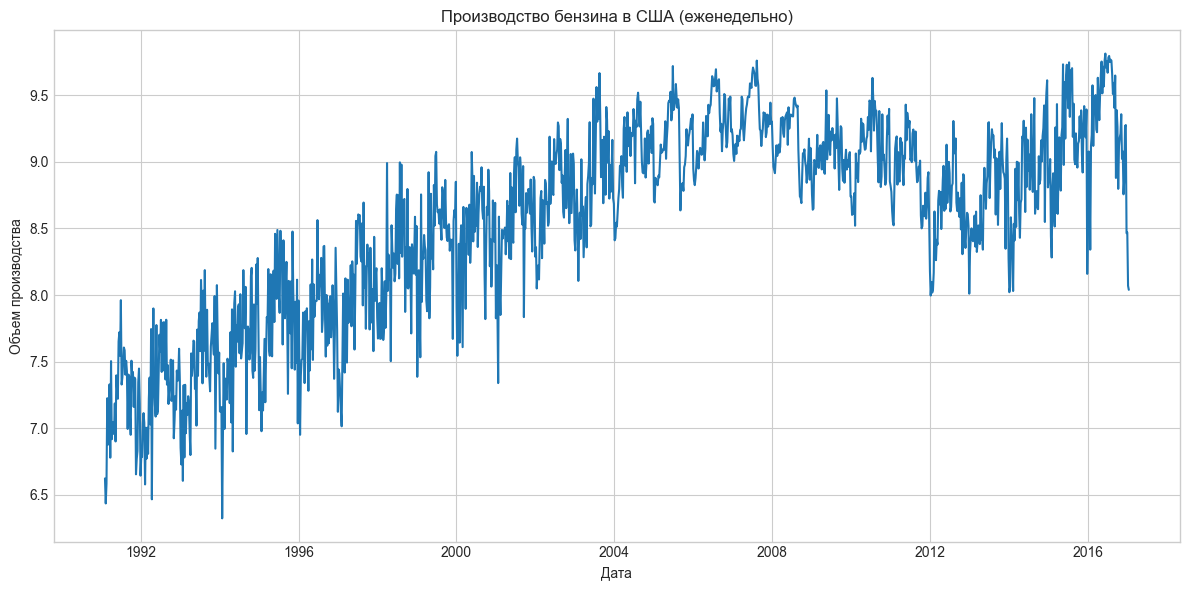

In [23]:
# Визуализация временного ряда производства бензина
plt.figure(figsize=(12, 6))
plt.plot(gas_df.index, gas_df['value'])
plt.title('Производство бензина в США (еженедельно)')
plt.xlabel('Дата')
plt.ylabel('Объем производства')
plt.legend()
plt.tight_layout()
plt.show()

**Задание 9. Ресэмплинг для агрегации данных**

Исходные данные имеют еженедельную частоту, что делает график 'шумным'. Преобразуйте ряд в ежемесячный (`'M'`), агрегируя значения с помощью среднего (`.mean()`). Сохраните результат в `gas_monthly` и постройте график.

C:\Users\USER\AppData\Local\Temp\ipykernel_2472\618152994.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gas_monthly = gas_df.resample('M').mean()
C:\Users\USER\AppData\Local\Temp\ipykernel_2472\618152994.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


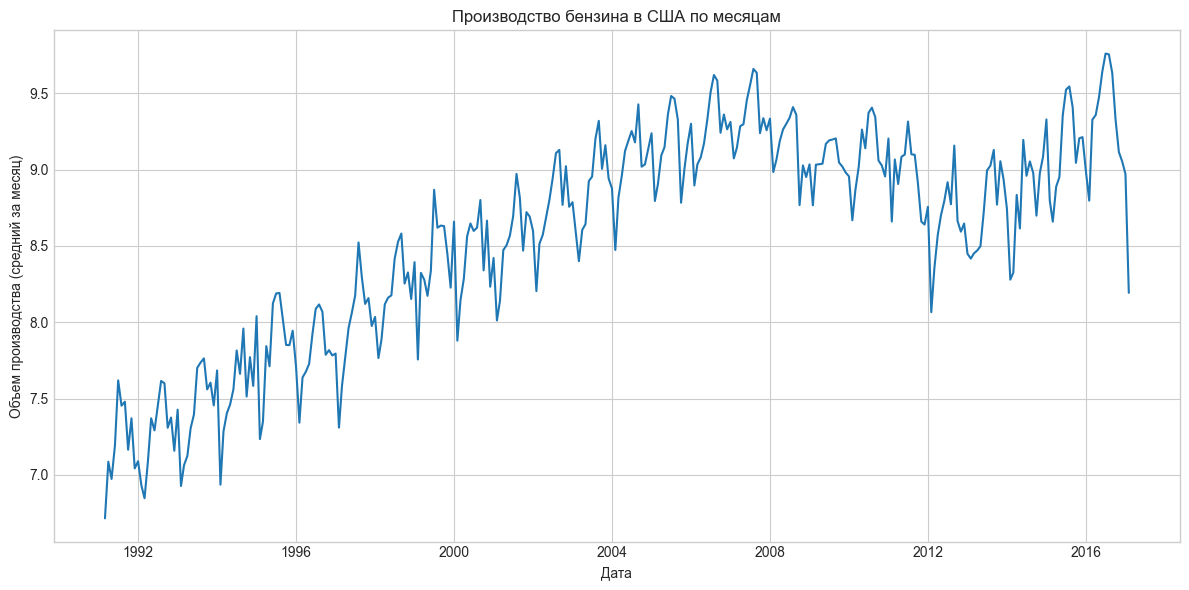

,value
date,
1991-02-28,6.71500
1991-03-31,7.08600
1991-04-30,6.97325
1991-05-31,7.19175
1991-06-30,7.61900


In [25]:
# Выполним ресэмплинг до ежемесячной частоты, усредняя значения
gas_monthly = gas_df.resample('M').mean()

# Построим график агрегированного ряда
plt.figure(figsize=(12, 6))
plt.plot(gas_monthly.index, gas_monthly['value'])
plt.title('Производство бензина в США по месяцам')
plt.xlabel('Дата')
plt.ylabel('Объем производства (средний за месяц)')
plt.legend()
plt.tight_layout()
plt.show()

gas_monthly.head()


**Задание 10. Сглаживание с помощью скользящего среднего**

Чтобы лучше увидеть долгосрочный тренд, примените скользящее среднее. Создайте новый столбец `'rolling_mean_12'` в `gas_monthly`, рассчитав среднее за 12 месяцев с помощью `.rolling(window=12).mean()`. Постройте на одном графике исходный ряд и сглаженный.

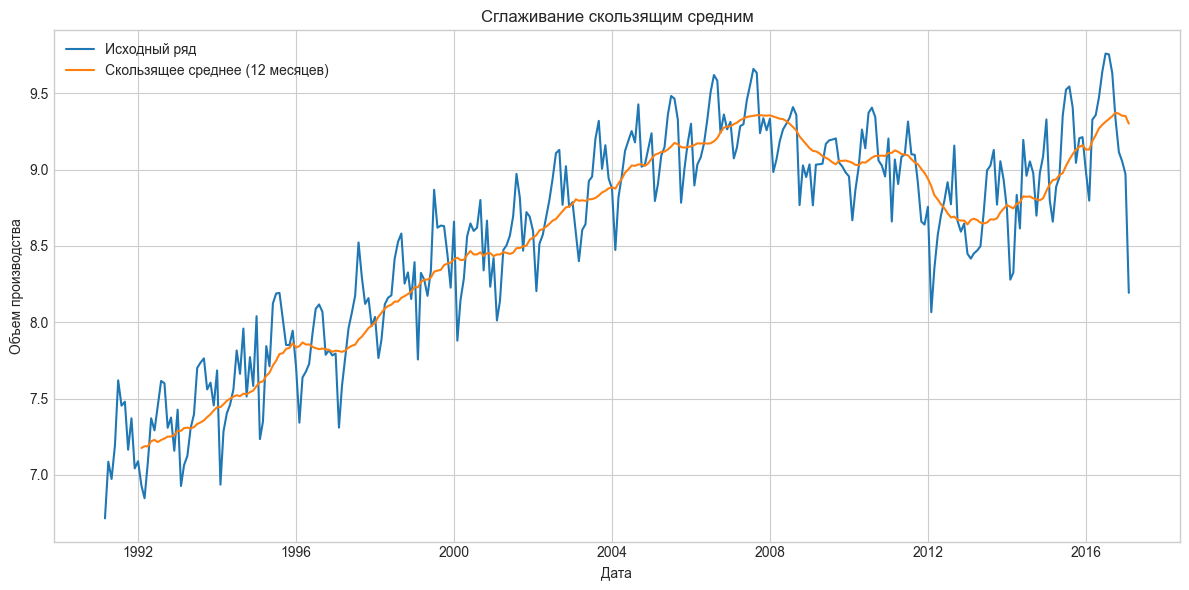

In [29]:
# 1. Рассчитаем скользящее среднее за 12 месяцев
gas_monthly['rolling_mean_12'] = gas_monthly['value'].rolling(window=12).mean()

# 2. Построим на одном графике исходный ряд и сглаженный
plt.figure(figsize=(12, 6))
plt.plot(gas_monthly.index, gas_monthly['value'], label='Исходный ряд')
plt.plot(gas_monthly.index, gas_monthly['rolling_mean_12'], label='Скользящее среднее (12 месяцев)')
plt.title('Сглаживание скользящим средним')
plt.xlabel('Дата')
plt.ylabel('Объем производства')
plt.legend()
plt.tight_layout()
plt.show()


**Задание 11. Декомпозиция временного ряда**

Используйте `seasonal_decompose` из `statsmodels`, чтобы разложить ежемесячный ряд `gas_monthly['value']` на тренд, сезонность и остаток. Визуализируйте результат с помощью метода `.plot()`.

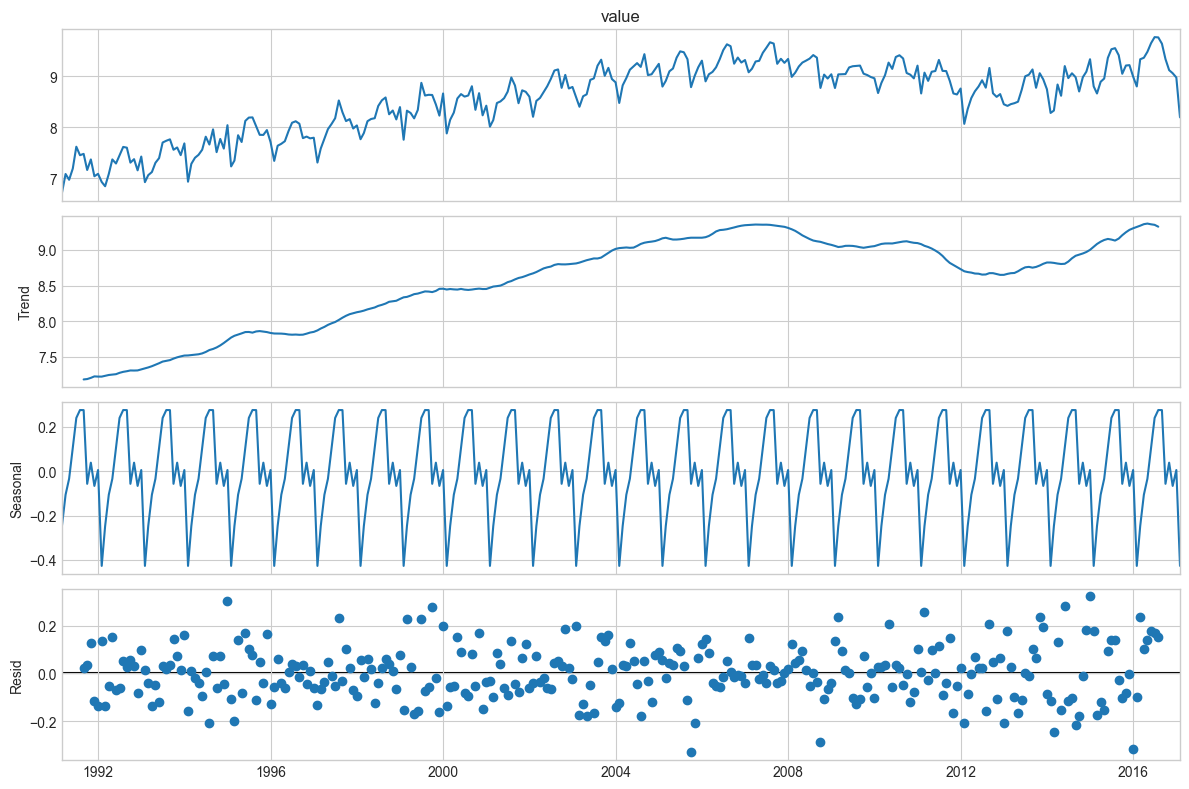

In [30]:
# Выполним декомпозицию ежемесячного ряда на компоненты
result = seasonal_decompose(gas_monthly['value'].dropna(), model='additive', period=12)

# Построим графики тренда, сезонности и остатка
fig = result.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
plt.show()


## Часть 3. Стационарность и корреляционный анализ

**Задание 12. Проверка на стационарность**

Проведите расширенный тест Дики-Фуллера (`adfuller`) для ряда `gas_monthly['value']`. Проанализируйте p-значение и сделайте вывод о стационарности ряда.

In [ ]:
# Проведение расширенного теста Дики-Фуллера для gas_monthly['value']
result_adf = adfuller(gas_monthly['value'].dropna())

adf_stat = result_adf[0]
p_value = result_adf[1]
critical_values = result_adf[4]

print('Тест Дики — Фуллера:', adf_stat)
print('p-значение:', p_value)
print('Критические значения:')
for k, value in critical_values.items():
    print(f'  Уровень значимости {k}: {value}')


Тест Дики — Фуллера: -2.197750310305142
p-значение: 0.2070629774633055
Критические значения:
  Уровень значимости 1%: -3.452713099849546
  Уровень значимости 5%: -2.871387839457783
  Уровень значимости 10%: -2.5720171933352485


**Исходный ряд нестационарен и его нужно дополнительно преобразовать (например, дифференцировать) перед построением моделей, требующих стационарности.**

**Задание 13. Достижение стационарности через дифференцирование**

Чтобы сделать ряд стационарным, примените к нему дифференцирование первого порядка с помощью метода `.diff()`. Удалите появившееся значение `NaN` и сохраните результат в `gas_monthly_diff`.

In [35]:
# Дифференцирование первого порядка для достижения стационарности
gas_monthly_diff = gas_monthly['value'].diff().dropna()
gas_monthly_diff


date
1991-03-31    0.371000
1991-04-30   -0.112750
1991-05-31    0.218500
1991-06-30    0.427250
1991-07-31   -0.165750
                ...   
2016-09-30   -0.300250
2016-10-31   -0.216300
2016-11-30   -0.060200
2016-12-31   -0.083500
2017-01-31   -0.778833
Freq: ME, Name: value, Length: 311, dtype: float64

**Задание 14. Повторная проверка на стационарность**

Проведите тест Дики-Фуллера для нового, дифференцированного ряда `gas_monthly_diff`. Сравните p-значение с предыдущим результатом.

In [36]:
# Тест Дики-Фуллера для дифференцированного ряда gas_monthly_diff
result_adf_diff = adfuller(gas_monthly_diff.dropna())

adf_stat_diff = result_adf_diff[0]
p_value_diff = result_adf_diff[1]
critical_values_diff = result_adf_diff[4]

print('ADF-статистика (дифференцированный ряд):', adf_stat_diff)
print('p-значение:', p_value_diff)
print('Критические значения:')
for key, value in critical_values_diff.items():
    print(f'  Уровень значимости {key}: {value}')


ADF-статистика (дифференцированный ряд): -3.0639228958364275
p-значение: 0.029340836396291082
Критические значения:
  Уровень значимости 1%: -3.452789844280995
  Уровень значимости 5%: -2.871421512222641
  Уровень значимости 10%: -2.5720351510944512


**Дифференцированный ряд можно считать стационарным**

**Задание 15. Анализ автокорреляции (ACF)**

Постройте график автокорреляционной функции (ACF) для стационарного ряда `gas_monthly_diff`. Это поможет определить порядок компоненты MA в модели ARIMA.

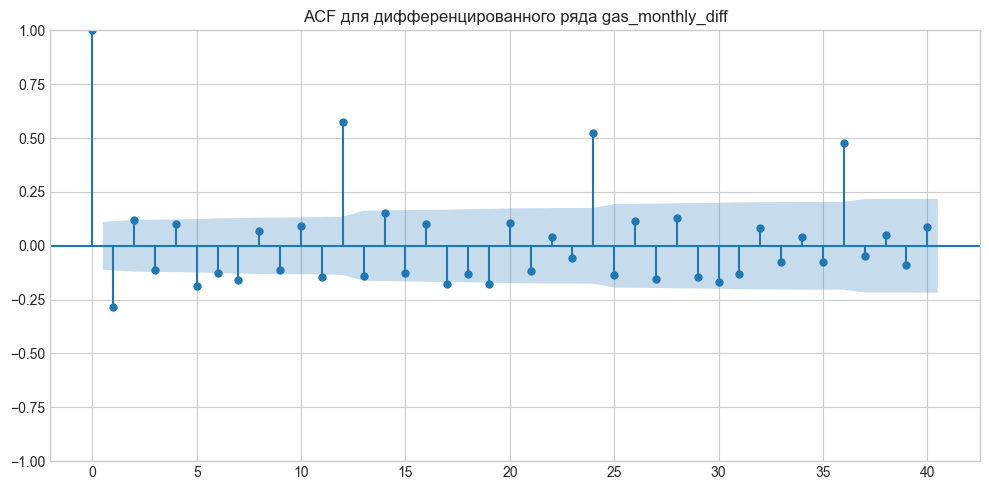

In [37]:
# График автокорреляционной функции (ACF) для стационарного ряда gas_monthly_diff
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(gas_monthly_diff.dropna(), ax=ax, lags=40)
ax.set_title('ACF для дифференцированного ряда gas_monthly_diff')
plt.tight_layout()
plt.show()


**Задание 16. Анализ частичной автокорреляции (PACF)**

Постройте график частичной автокорреляционной функции (PACF) для `gas_monthly_diff`. Это поможет определить порядок компоненты AR в модели ARIMA.

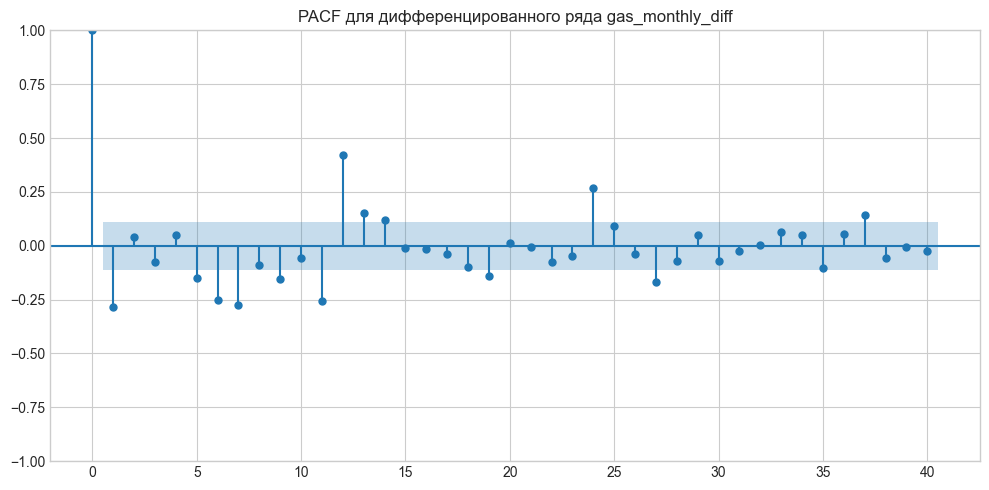

In [38]:
# График частичной автокорреляционной функции (PACF) для стационарного ряда gas_monthly_diff
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(gas_monthly_diff.dropna(), ax=ax, lags=40, method='ywm')
ax.set_title('PACF для дифференцированного ряда gas_monthly_diff')
plt.tight_layout()
plt.show()


## Часть 4. Построение и оценка прогнозной модели ARIMA

Модель ARIMA (AutoRegressive Integrated Moving Average) — одна из самых популярных моделей для прогнозирования временных рядов.

- **AR (p):** Авторегрессионная часть, использующая зависимость от `p` предыдущих значений.
- **I (d):** Интегрированная часть, отвечающая за количество дифференцирований (`d`) для достижения стационарности.
- **MA (q):** Часть скользящего среднего, использующая зависимость от `q` предыдущих ошибок прогноза.

**Задание 17. Разделение данных на обучающую и тестовую выборки**

Разделите `gas_monthly['value']` на обучающую (все данные до 2015 года) и тестовую (данные с 2015 года) выборки. Это позволит нам оценить качество модели на данных, которые она не видела при обучении.

In [47]:
# Разделение данных на обучающую и тестовую выборки
train_data = gas_monthly['value'].loc[:'2014-12-31']
test_data = gas_monthly['value'].loc['2015-01-01':]

print('Длина обучающей выборки:', len(train_data))
print('Длина тестовой выборки:', len(test_data))
print(train_data,test_data)


Длина обучающей выборки: 287
Длина тестовой выборки: 25
date
1991-02-28    6.71500
1991-03-31    7.08600
1991-04-30    6.97325
1991-05-31    7.19175
1991-06-30    7.61900
               ...   
2014-08-31    8.97760
2014-09-30    8.69825
2014-10-31    8.97700
2014-11-30    9.08540
2014-12-31    9.32850
Freq: ME, Name: value, Length: 287, dtype: float64 date
2015-01-31    8.797500
2015-02-28    8.659000
2015-03-31    8.887800
2015-04-30    8.951000
2015-05-31    9.354800
2015-06-30    9.523500
2015-07-31    9.544750
2015-08-31    9.407000
2015-09-30    9.044250
2015-10-31    9.205250
2015-11-30    9.212800
2015-12-31    8.989750
2016-01-31    8.796600
2016-02-29    9.327750
2016-03-31    9.357250
2016-04-30    9.473500
2016-05-31    9.642600
2016-06-30    9.760250
2016-07-31    9.754800
2016-08-31    9.631750
2016-09-30    9.331500
2016-10-31    9.115200
2016-11-30    9.055000
2016-12-31    8.971500
2017-01-31    8.192667
Freq: ME, Name: value, dtype: float64


**Задание 18. Обучение модели ARIMA**

Обучите модель ARIMA на обучающей выборке (`train_data`). На основе графиков ACF/PACF и того, что мы применили одно дифференцирование, выберем порядок `(p, d, q) = (2, 1, 2)`. Выведите сводку по модели с помощью `.summary()`.

In [48]:
# Создаём модель ARIMA с параметрами (p, d, q) = (2, 1, 2)
model = ARIMA(train_data, order=(2, 1, 2))

# Обучаем модель на обучающей выборке
model_fit = model.fit()

# Выводим сводку по модели
model_fit.summary()


C:\Users\USER\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\USER\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\USER\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  287
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  38.572
Date:                Wed, 03 Dec 2025   AIC                            -67.144
Time:                        15:48:22   BIC                            -48.864
Sample:                    02-28-1991   HQIC                           -59.817
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4031      0.087     -4.658      0.000      -0.573      -0.233
ar.L2          0.5969      0.086      6.917      0.000       0.428       0.766
ma.L1          0.1049      0.075      1.404      0.160      -0.041       0.251
ma.L2         -0.8899      0.067    -13.188      0.000      -1.022      -0.758
sigma2         0.0442      0.004     11.357      0.000       0.037       0.052
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                11.01
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.32
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Задание 19. Построение прогноза**

Сделайте прогноз на период, соответствующий тестовой выборке. Используйте `model_fit.predict()`, указав `start` и `end` индексы тестовой выборки.

In [50]:
# Прогноз на период тестовой выборки
start = test_data.index[0]
end = test_data.index[-1]

forecast = model_fit.predict(start=start, end=end)

# Сравним размерности прогноза и тестовых данных
print('Длина прогноза:', len(forecast))
print('Длина тестовой выборки:', len(test_data))

forecast


Длина прогноза: 25
Длина тестовой выборки: 25


2015-01-31    9.114077
2015-02-28    9.128992
2015-03-31    8.994991
2015-04-30    9.057903
2015-05-31    8.952561
2015-06-30    9.032572
2015-07-31    8.937445
2015-08-31    9.023544
2015-09-30    8.932060
2015-10-31    9.020326
2015-11-30    8.930144
2015-12-31    9.019178
2016-01-31    8.929462
2016-02-29    9.018767
2016-03-31    8.929221
2016-04-30    9.018619
2016-05-31    8.929137
2016-06-30    9.018564
2016-07-31    8.929109
2016-08-31    9.018543
2016-09-30    8.929100
2016-10-31    9.018534
2016-11-30    8.929099
2016-12-31    9.018529
2017-01-31    8.929100
Freq: ME, Name: predicted_mean, dtype: float64

**Задание 20. Визуализация прогноза**

Постройте график, на котором будут отображены обучающие данные, реальные тестовые данные и ваш прогноз.

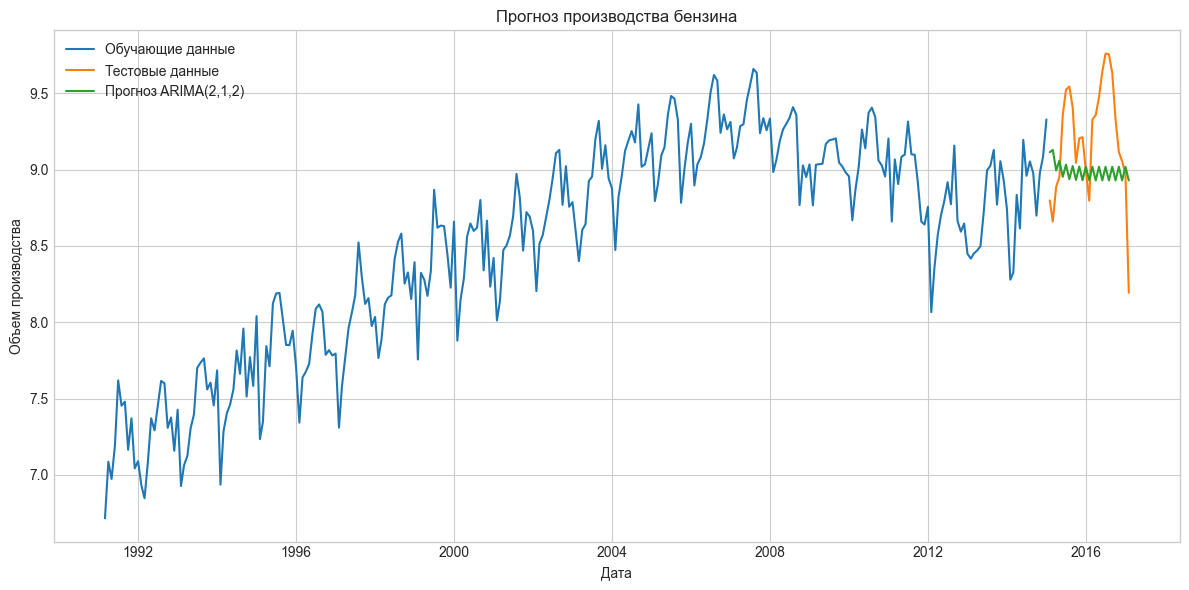

In [54]:
# Визуализация обучающих данных, тестовой выборки и прогноза
plt.figure(figsize=(12, 6))

# Обучающая выборка
plt.plot(train_data.index, train_data, label='Обучающие данные')

# Тестовая выборка
plt.plot(test_data.index, test_data, label='Тестовые данные')

# Прогноз
plt.plot(forecast.index, forecast, label='Прогноз ARIMA(2,1,2)')

plt.title('Прогноз производства бензина')
plt.xlabel('Дата')
plt.ylabel('Объем производства')
plt.legend()
plt.tight_layout()
plt.show()


**Задание 21. Оценка качества модели**

Рассчитайте метрику RMSE (Root Mean Squared Error) для оценки точности вашего прогноза. RMSE = `sqrt(mean_squared_error(y_true, y_pred))`.

In [ ]:
# Расчёт RMSE между реальными значениями тестовой выборки и прогнозом
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print('RMSE прогноза на тестовой выборке:', rmse)

RMSE прогноза на тестовой выборке: 0.43552592642404664


**Задание 22. Прогноз на будущее**

Теперь, когда модель оценена, используйте ее для прогнозирования на 12 месяцев вперед (за пределы имеющихся данных). Используйте метод `.forecast()`.

In [58]:
# Прогноз на 12 месяцев вперёд за пределами имеющихся данных
future_forecast = model_fit.forecast(steps=12)

print('Прогноз на 12 будущих месяцев:')
future_forecast


Прогноз на 12 будущих месяцев:


2015-01-31    9.114077
2015-02-28    9.128992
2015-03-31    8.994991
2015-04-30    9.057903
2015-05-31    8.952561
2015-06-30    9.032572
2015-07-31    8.937445
2015-08-31    9.023544
2015-09-30    8.932060
2015-10-31    9.020326
2015-11-30    8.930144
2015-12-31    9.019178
Freq: ME, Name: predicted_mean, dtype: float64

**Задание 23. Визуализация прогноза на будущее**

Постройте график, включающий все исторические данные (`gas_monthly['value']`) и прогноз на будущее.

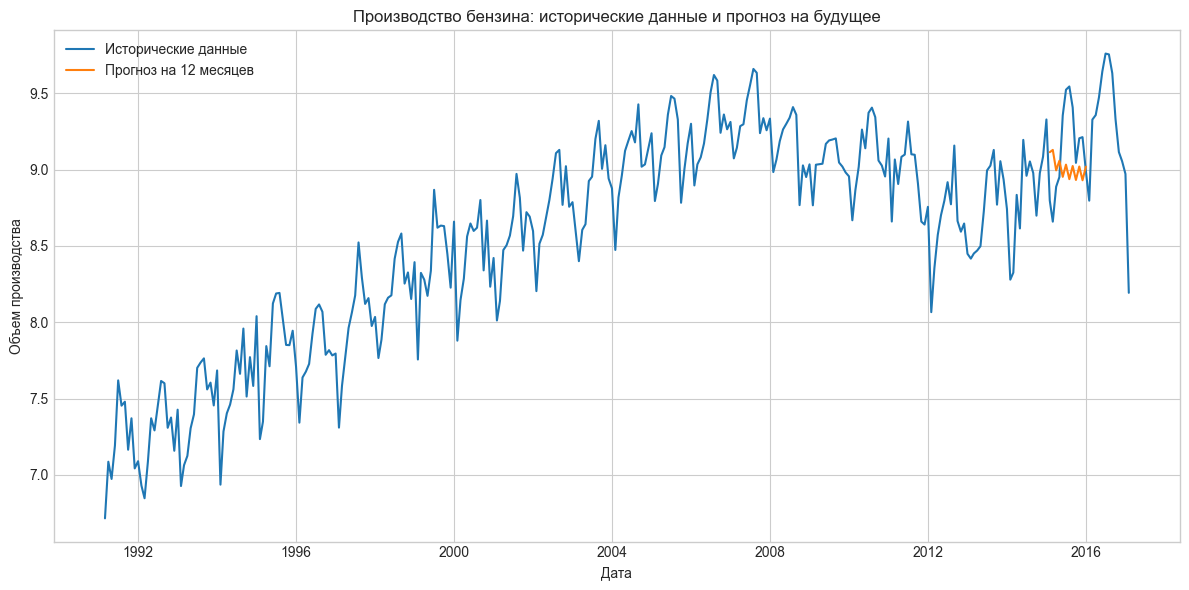

In [60]:
# Визуализация исторических данных и прогноза на будущее
plt.figure(figsize=(12, 6))

# Все исторические данные
plt.plot(gas_monthly.index, gas_monthly['value'], label='Исторические данные')

# Прогноз на будущее (12 месяцев вперёд)
plt.plot(future_forecast.index, future_forecast, label='Прогноз на 12 месяцев')

plt.title('Производство бензина: исторические данные и прогноз на будущее')
plt.xlabel('Дата')
plt.ylabel('Объем производства')
plt.legend()
plt.tight_layout()
plt.show()


## Часть 5. Индивидуальные задания для самостоятельной работы

**Инструкция.** Выполните задания, соответствующие вашему варианту. В качестве основного набора данных используйте `gas_monthly` (ежемесячные данные о производстве бензина) или `unemployment_df` (квартальные данные об уровне безработицы), как указано в задании. Сначала загрузим второй датасет.

In [ ]:
unemployment_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_unemployment.csv"
unemployment_df = pd.read_csv(unemployment_url, parse_dates=['date'], index_col='date')
print("Данные по безработице (head):")
print(unemployment_df.head())

print("\nДанные по производству бензина (head):")
print(gas_monthly.head())


**Вариант 19:**
1. **Данные:** `gas_monthly`
2. **EDA:** Агрегируйте данные до годовой частоты по максимальному значению и постройте график.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,2) на данных до 2014 года.
5. **Прогноз:** Сделайте и визуализируйте прогноз на оставшихся данных (тестовый период).

In [63]:
# Задание 1
gas_monthly


,value,rolling_mean_12
date,,
1991-02-28,6.715000,NaN
1991-03-31,7.086000,NaN
1991-04-30,6.973250,NaN
1991-05-31,7.191750,NaN
1991-06-30,7.619000,NaN
...,...,...
2016-09-30,9.331500,9.373650
2016-10-31,9.115200,9.366146
2016-11-30,9.055000,9.352996


C:\Users\USER\AppData\Local\Temp\ipykernel_2472\213556730.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  gas_yearly_max = gas_monthly['value'].resample('A').max()


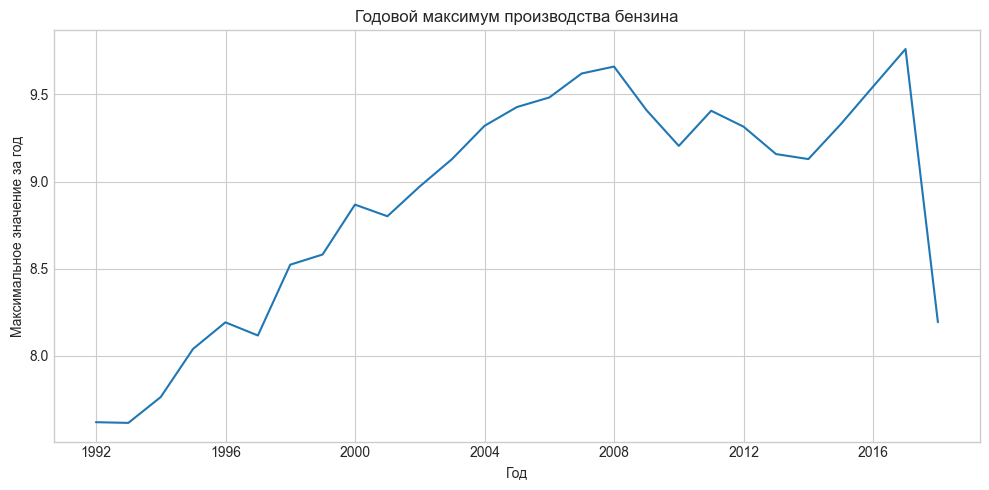

date
1991-12-31    7.619000
1992-12-31    7.615000
1993-12-31    7.763200
1994-12-31    8.039500
1995-12-31    8.192000
1996-12-31    8.116500
1997-12-31    8.522750
1998-12-31    8.581200
1999-12-31    8.867500
2000-12-31    8.800750
2001-12-31    8.971800
2002-12-31    9.129250
2003-12-31    9.319400
2004-12-31    9.427400
2005-12-31    9.482250
2006-12-31    9.619800
2007-12-31    9.659600
2008-12-31    9.409500
2009-12-31    9.204400
2010-12-31    9.406000
2011-12-31    9.314750
2012-12-31    9.157500
2013-12-31    9.128750
2014-12-31    9.328500
2015-12-31    9.544750
2016-12-31    9.760250
2017-12-31    8.192667
Freq: YE-DEC, Name: value, dtype: float64

In [66]:
# Задание 2
gas_yearly_max = gas_monthly['value'].resample('A').max()

plt.figure(figsize=(10, 5))
plt.plot(gas_yearly_max.index, gas_yearly_max)
plt.title('Годовой максимум производства бензина')
plt.xlabel('Год')
plt.ylabel('Максимальное значение за год')
plt.tight_layout()
plt.show()

gas_yearly_max



<Figure size 1000x500 with 0 Axes>

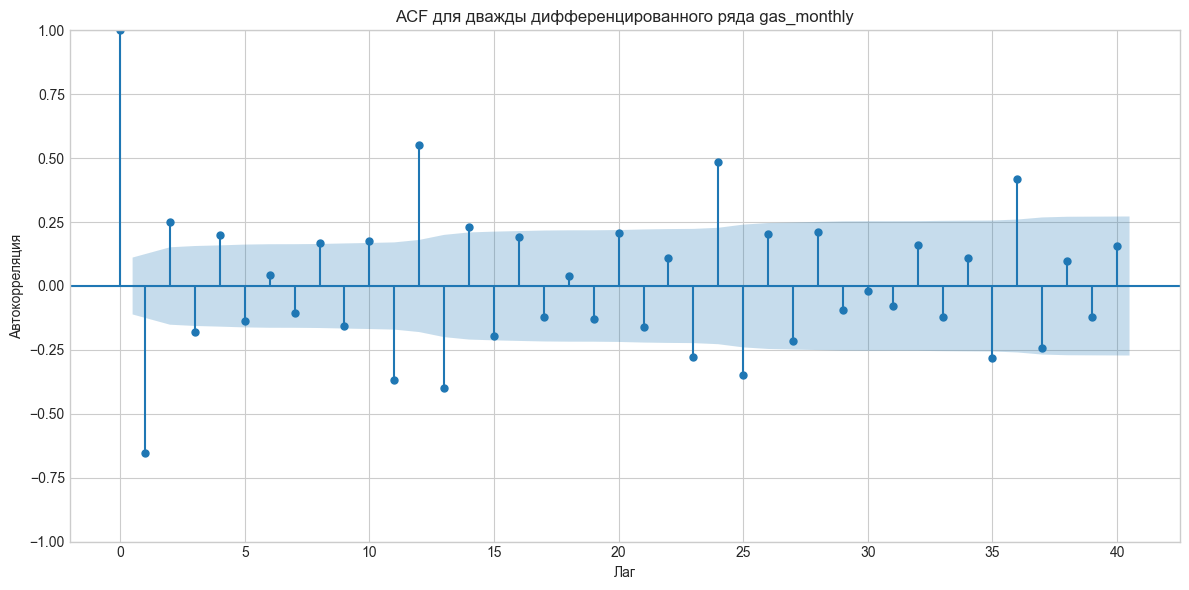

In [67]:
# Задание 3
# Дважды дифференцируем ежемесячный ряд и строим ACF

gas_monthly_diff2 = gas_monthly['value'].diff().diff().dropna()

plt.figure(figsize=(10, 5))
plot_acf(gas_monthly_diff2, lags=40)
plt.title('ACF для дважды дифференцированного ряда gas_monthly')
plt.xlabel('Лаг')
plt.ylabel('Автокорреляция')
plt.tight_layout()
plt.show()


In [68]:
# Задание 4
# Обучаем модель ARIMA(1,2,2) на данных до конца 2014 года

train_data_v19 = gas_monthly['value'].loc[:'2014-12-31']

model_v19 = ARIMA(train_data_v19, order=(1, 2, 2))
model_v19_fit = model_v19.fit()

model_v19_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  287
Model:                 ARIMA(1, 2, 2)   Log Likelihood                  18.011
Date:                Wed, 03 Dec 2025   AIC                            -28.022
Time:                        17:46:47   BIC                            -13.412
Sample:                    02-28-1991   HQIC                           -22.165
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      0.001  -1281.705      0.000      -1.002      -0.998
ma.L1         -0.0022      0.060     -0.037      0.971      -0.120       0.115
ma.L2         -0.9978      0.060    -16.666      0.000      -1.115      -0.880
sigma2         0.0500      0.005     10.960      0.000       0.041       0.059
===================================================================================
Ljung-Box (L1) (Q):                  13.20   Jarque-Bera (JB):                 4.36
Prob(Q):                              0.00   Prob(JB):                         0.11
Heteroskedasticity (H):               0.80   Skew:                            -0.22
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.04e+16. Standard errors may be unstable.
"""

Длина тестовой выборки: 25
Длина прогноза: 25


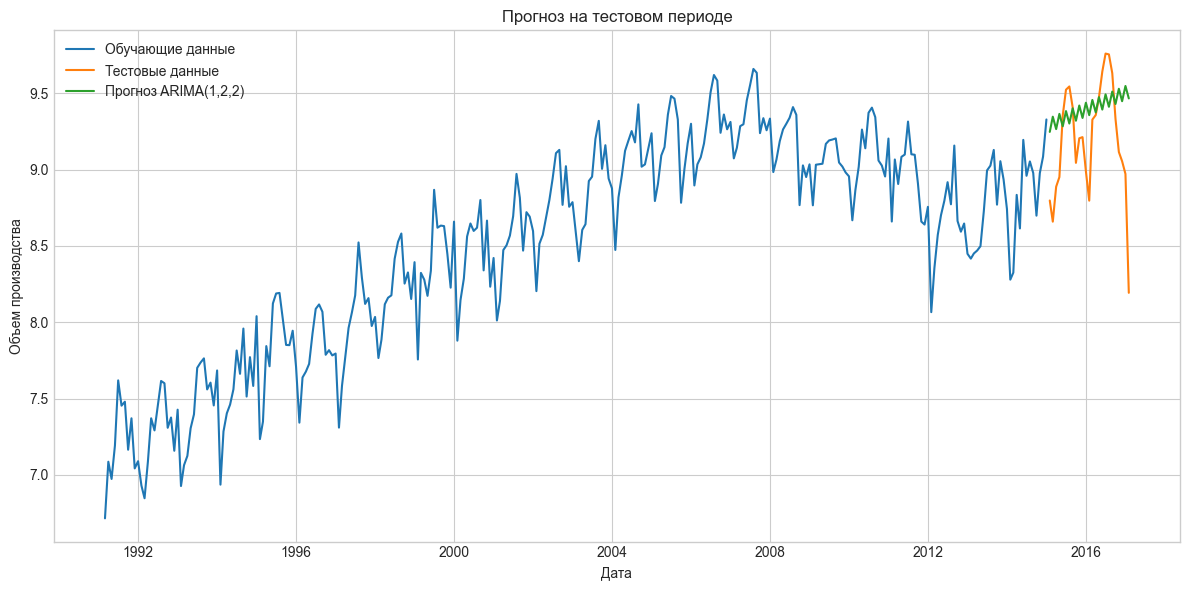

In [71]:
# Задание 5
# Прогноз на тестовый период (данные после 2014-12-31) и его визуализация

# Тестовый период
test_data_v19 = gas_monthly['value'].loc['2015-01-01':]

# Строим прогноз на длину тестового периода
forecast_v19 = model_v19_fit.predict(start=test_data_v19.index[0], end=test_data_v19.index[-1])

print('Длина тестовой выборки:', len(test_data_v19))
print('Длина прогноза:', len(forecast_v19))

# Визуализация
plt.figure(figsize=(12, 6))

# Обучающая часть
plt.plot(train_data_v19.index, train_data_v19, label='Обучающие данные')

# Тестовая часть (фактические значения)
plt.plot(test_data_v19.index, test_data_v19, label='Тестовые данные')

# Прогноз модели ARIMA(1,2,2)
plt.plot(forecast_v19.index, forecast_v19, label='Прогноз ARIMA(1,2,2)')

plt.title('Прогноз на тестовом периоде')
plt.xlabel('Дата')
plt.ylabel('Объем производства')
plt.legend()
plt.tight_layout()
plt.show()
